## Importing Libraries

In [1]:
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

## Importing the Data

In [2]:
# Step 1: Load the JSON file
with open("dunya_predicted_articles.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [3]:
# Just keep first 500 articles for now (Run this if you want to perform the task with a sample)
#data_subset = data[:500]
data_subset = data


In [4]:
# Convert to DataFrame
data_subset = pd.DataFrame(data_subset)
data_subset = data_subset[data_subset['prediction'] == 1]

data_subset.rename(columns={'prediction': 'prediction_economicrelationship'}, inplace=True)

# Now check unique values of the "year" column
print(data_subset["year"].unique())

['2014' '2008' '2010' '2021' '2013' '2020' '2017' '2016' '2019' '2018'
 '2012' '2015' '2009' '2022' '2011']


In [5]:
# Count number of observations per year
year_counts = data_subset["year"].value_counts().sort_index()

# Display the result
print(year_counts)


year
2008    329
2009    180
2010    215
2011    203
2012    330
2013    383
2014    377
2015    343
2016    404
2017    519
2018    391
2019    380
2020    539
2021    458
2022    164
Name: count, dtype: int64


In [6]:
data_subset.head()

,published_date,update,category,url,title,abstract,content,language,docname,yatırım,predicted_label1,year,all_texts,prediction_economicrelationship
3,2014-04-30 12:27:54+00:00,2014-04-30T15:27:54+03:00,sektorler_tekstil,https://www.dunya.com/sektorler/tekstil/cin039...,"Çin'de lüks tüketiminin artması, Türk hazır gi...","UHKİB Başkanı Şankaya, Türkiye'nin, Avrupa ülk...",\nBURSA - Uludağ Hazır Giyim ve Konfeksiyon İh...,turkish,text166114,0.1311,1,2014,"Çin'de lüks tüketiminin artması, Türk hazır gi...",1
6,2014-10-15 18:39:48+00:00,2014-10-15T21:39:48+03:00,is-dunyasi,https://www.dunya.com/is-dunyasi/yuksek-katma-...,"Yüksek katma değeri, ilaç sanayi ile sağlayacak","Türkiye İhracatçılar Meclisi bünyesindeki, TİM...",\nHATİCE KEVEN ŞİMŞEKKAYSERİ - Kayseri Organiz...,turkish,text166191,0.722,1,2014,"Yüksek katma değeri, ilaç sanayi ile sağlayaca...",1
7,2014-05-07 07:12:39+00:00,2014-05-07T10:12:39+03:00,ekonomi,https://www.dunya.com/ekonomi/beklenen-havacil...,Beklenen havacılık kararları çıkmadı,"Türkiye F35 JSF uçak siparişini bir kez daha ""...",\nMehmet KAYA ANKARA - Savunma Sanayii İcra Ko...,turkish,text166197,0.6974,1,2014,Beklenen havacılık kararları çıkmadı\nTürkiye ...,1
11,2008-05-04 21:00:00+00:00,2008-05-05T00:00:00+03:00,ekonomi,https://www.dunya.com/ekonomi/dunya-deri-sekto...,Dünya deri sektörü Türk başkana emanet,Dünya deri sektörü Türk başkana emanet,\nİSTANBUL - Deri sektörünün dünyadaki en büyü...,turkish,text166267,-0.2332,1,2008,Dünya deri sektörü Türk başkana emanet\nDünya ...,1
17,2010-06-19 13:49:16+00:00,2010-06-19T16:49:16+03:00,gundem,https://www.dunya.com/gundem/libya039da-is-yap...,Libya'da iş yapan Türk müteahhitlere müjde,"Bakan Çağlayan, Türk müteahhitlerinin Libya'da...","\nANKARA - Devlet Bakanı Zafer Çağlayan, Libya...",turkish,text166357,1.1379,1,2010,Libya'da iş yapan Türk müteahhitlere müjde\nBa...,1


In [7]:
len(data_subset)

5215

In [8]:
texts = data_subset["all_texts"].tolist()

## Model Initialization

In [9]:
model_path = "/content/bert_cooperation_model_optimized_dual.pth"


# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load tokenizer and model config
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-cased")
model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-cased",
    num_labels=2  # or 3, depending on your setup
)

# Load weights (assuming it was saved using model.state_dict())
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [10]:

# Step 4: Dataset and DataLoader
class ArticleDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(),
            'attention_mask': encoded['attention_mask'].squeeze()
        }

# Step 4: DataLoader for batch prediction
dataset = ArticleDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Step 5: Predict
all_preds = []
with torch.no_grad():
    for batch in tqdm(dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().tolist())

100%|██████████| 163/163 [01:26<00:00,  1.89it/s]


## Saving the Results

In [12]:
import re

data_subset["prediction"] = [int(pred) for pred in all_preds]


# Step 4: Remove illegal characters from Excel-incompatible cells
def remove_illegal_chars(text):
    if isinstance(text, str):
        return re.sub(r"[\x00-\x1F\x7F]", "", text)
    return text

for col in data_subset.select_dtypes(include=["object"]):
    data_subset[col] = data_subset[col].map(remove_illegal_chars)

# Step 5: Save to Excel
data_subset.to_excel("dunya_cooperation_predicted_articles.xlsx", index=False)
print("✅ Saved cleaned DataFrame to 'dunya_cooperation_predicted_articles.xlsx'")

✅ Saved cleaned DataFrame to 'dunya_cooperation_predicted_articles.xlsx'


## Taking a Random Sample for Observing the Performance of the Model

In [13]:
data_subset.head()

,published_date,update,category,url,title,abstract,content,language,docname,yatırım,predicted_label1,year,all_texts,prediction_economicrelationship,prediction
3,2014-04-30 12:27:54+00:00,2014-04-30T15:27:54+03:00,sektorler_tekstil,https://www.dunya.com/sektorler/tekstil/cin039...,"Çin'de lüks tüketiminin artması, Türk hazır gi...","UHKİB Başkanı Şankaya, Türkiye'nin, Avrupa ülk...",BURSA - Uludağ Hazır Giyim ve Konfeksiyon İhra...,turkish,text166114,0.1311,1,2014,"Çin'de lüks tüketiminin artması, Türk hazır gi...",1,1
6,2014-10-15 18:39:48+00:00,2014-10-15T21:39:48+03:00,is-dunyasi,https://www.dunya.com/is-dunyasi/yuksek-katma-...,"Yüksek katma değeri, ilaç sanayi ile sağlayacak","Türkiye İhracatçılar Meclisi bünyesindeki, TİM...",HATİCE KEVEN ŞİMŞEKKAYSERİ - Kayseri Organize ...,turkish,text166191,0.722,1,2014,"Yüksek katma değeri, ilaç sanayi ile sağlayaca...",1,1
7,2014-05-07 07:12:39+00:00,2014-05-07T10:12:39+03:00,ekonomi,https://www.dunya.com/ekonomi/beklenen-havacil...,Beklenen havacılık kararları çıkmadı,"Türkiye F35 JSF uçak siparişini bir kez daha ""...",Mehmet KAYA ANKARA - Savunma Sanayii İcra Komi...,turkish,text166197,0.6974,1,2014,Beklenen havacılık kararları çıkmadıTürkiye F3...,1,0
11,2008-05-04 21:00:00+00:00,2008-05-05T00:00:00+03:00,ekonomi,https://www.dunya.com/ekonomi/dunya-deri-sekto...,Dünya deri sektörü Türk başkana emanet,Dünya deri sektörü Türk başkana emanet,İSTANBUL - Deri sektörünün dünyadaki en büyük ...,turkish,text166267,-0.2332,1,2008,Dünya deri sektörü Türk başkana emanetDünya de...,1,1
17,2010-06-19 13:49:16+00:00,2010-06-19T16:49:16+03:00,gundem,https://www.dunya.com/gundem/libya039da-is-yap...,Libya'da iş yapan Türk müteahhitlere müjde,"Bakan Çağlayan, Türk müteahhitlerinin Libya'da...","ANKARA - Devlet Bakanı Zafer Çağlayan, Libya'd...",turkish,text166357,1.1379,1,2010,Libya'da iş yapan Türk müteahhitlere müjdeBaka...,1,1


In [14]:
len(data_subset)

5215

In [15]:
data_subset.iloc[0, 8]

'text166114'

In [16]:
# Filter separately by prediction values
subset_1 = data_subset[data_subset['prediction'] == 1].sample(n=50, random_state=42)
subset_0 = data_subset[data_subset['prediction'] == 0].sample(n=50, random_state=42)

# Concatenate them into one dataframe
sample_data_subset = pd.concat([subset_1, subset_0]).sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
sample_data_subset.to_excel("sample_data_subset_dunya_cooperation.xlsx", index=False)

## Visualising the results

<ipython-input-19-8a70c9994523>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive["year"] = df_positive["year"].astype(int)


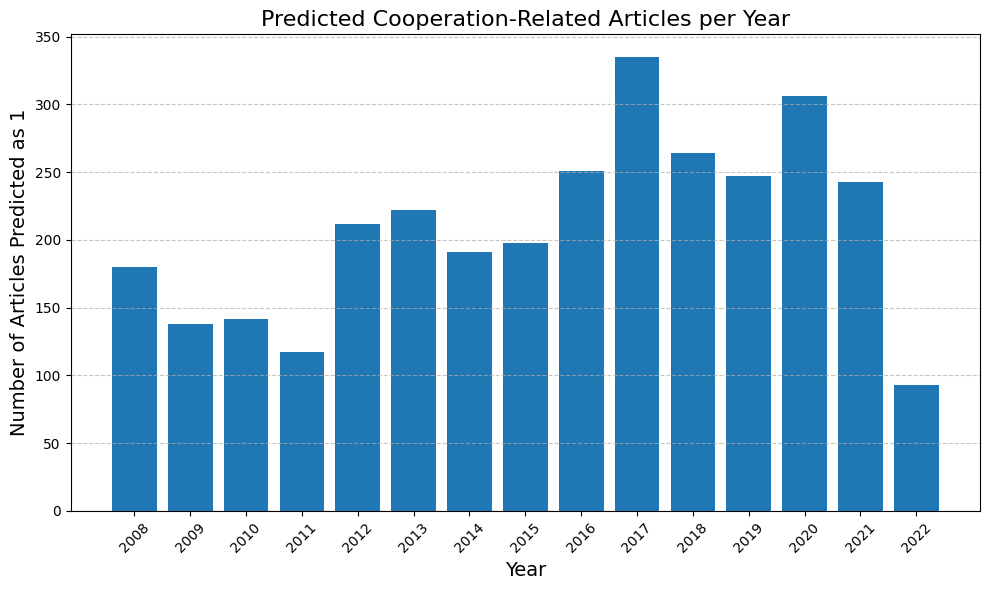

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert JSON subset (with prediction and year) to DataFrame
df = pd.DataFrame(data_subset)

# Ensure prediction is integer
df["prediction"] = df["prediction"].astype(int)

# Filter for only predictions == 1
df_positive = df[df["prediction"] == 1]

# Convert year to int
df_positive["year"] = df_positive["year"].astype(int)

# Count number of positive articles per year
year_counts = df_positive["year"].value_counts().sort_index()

# Auto-generate full year range based on existing data
min_year = df_positive["year"].min()
max_year = df_positive["year"].max()
full_year_range = range(min_year, max_year + 1)

# Reindex to ensure all years appear, even if count is 0
year_counts = year_counts.reindex(full_year_range, fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(year_counts.index, year_counts.values)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Articles Predicted as 1", fontsize=14)
plt.title("Predicted Cooperation-Related Articles per Year", fontsize=16)
plt.xticks(year_counts.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
